### Exploring HOG (aka traditional computer CV classifiers)

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from moviepy.editor import VideoFileClip
import time

In [5]:
from skimage.feature import hog
from skimage import color, exposure

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

Load the test images:

In [8]:
test_images_paths = glob.glob('test_images/*.jpg')
test_imgs = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in test_images_paths])

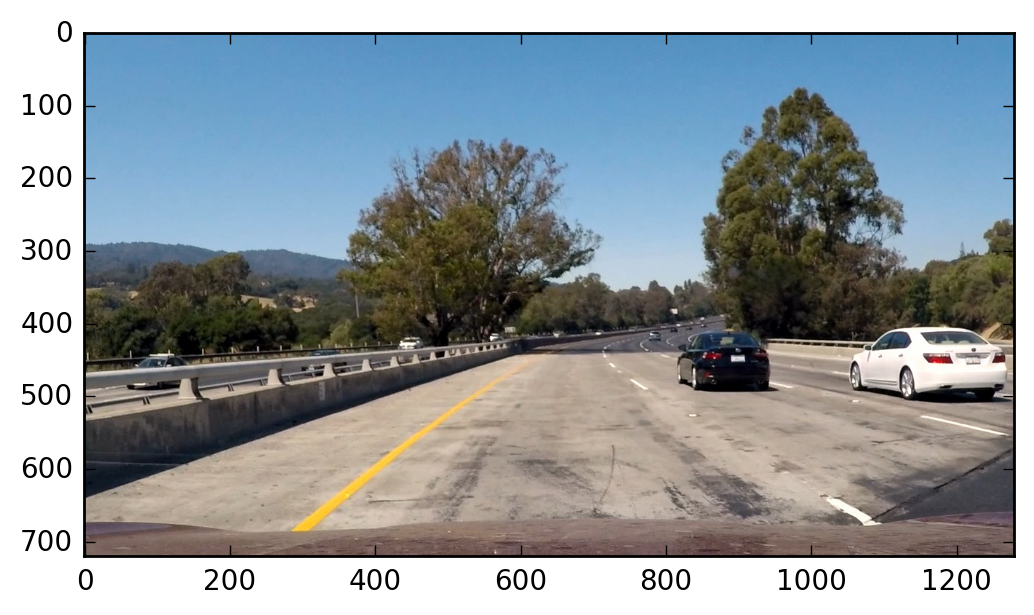

In [9]:
plt.imshow(test_imgs[0])

### training data for classification
The training data for the HOG classifier is from the KITTI dataset, as well as the 

In [11]:
img_extension = ['.png', '.jpg']
cars = []
notcars = []
for ext in img_extension:
    cars.extend(glob.glob('data/vehicles/**/*' + ext, recursive=True))
    notcars.extend(glob.glob('data/non-vehicles/**/*' + ext, recursive=True))
    

#### Exploring the dataset:

In [15]:
print('no. of cars training samples: ', len(cars))
print('no. of not-cars training samples: ', len(notcars))

no. of cars training samples:  8792
no. of not-cars training samples:  8968


The number of cars and non cars samples are roughly equal, so there should be no issues with a biased dataset. The below shows a random sample from each of the 2 classes-- as can be seen, not all of them are of such good quality...

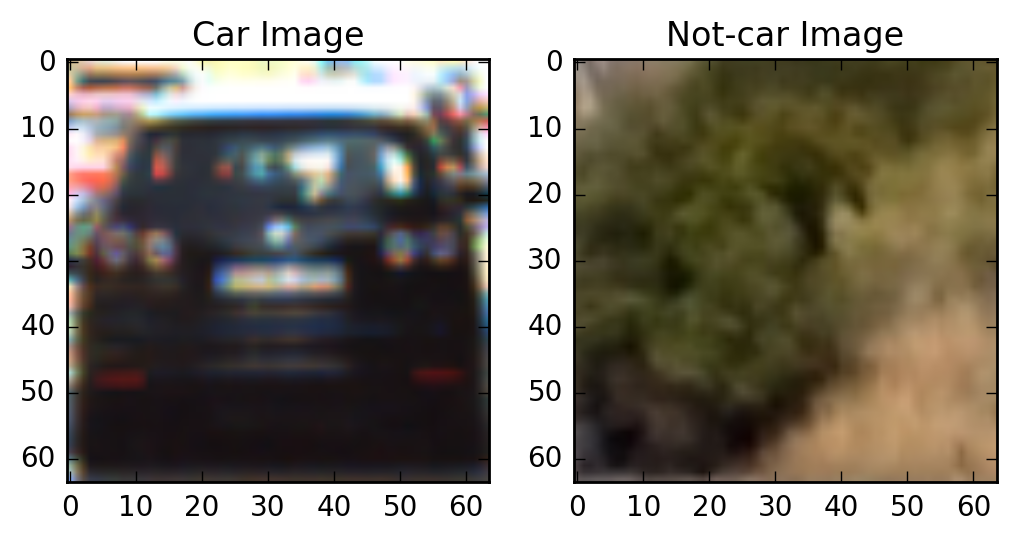

In [17]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
plt.title('Car Image')
plt.subplot(122)
plt.imshow(cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB))
plt.title('Not-car Image')

### Color features

In [9]:
#color histogram features  computation
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

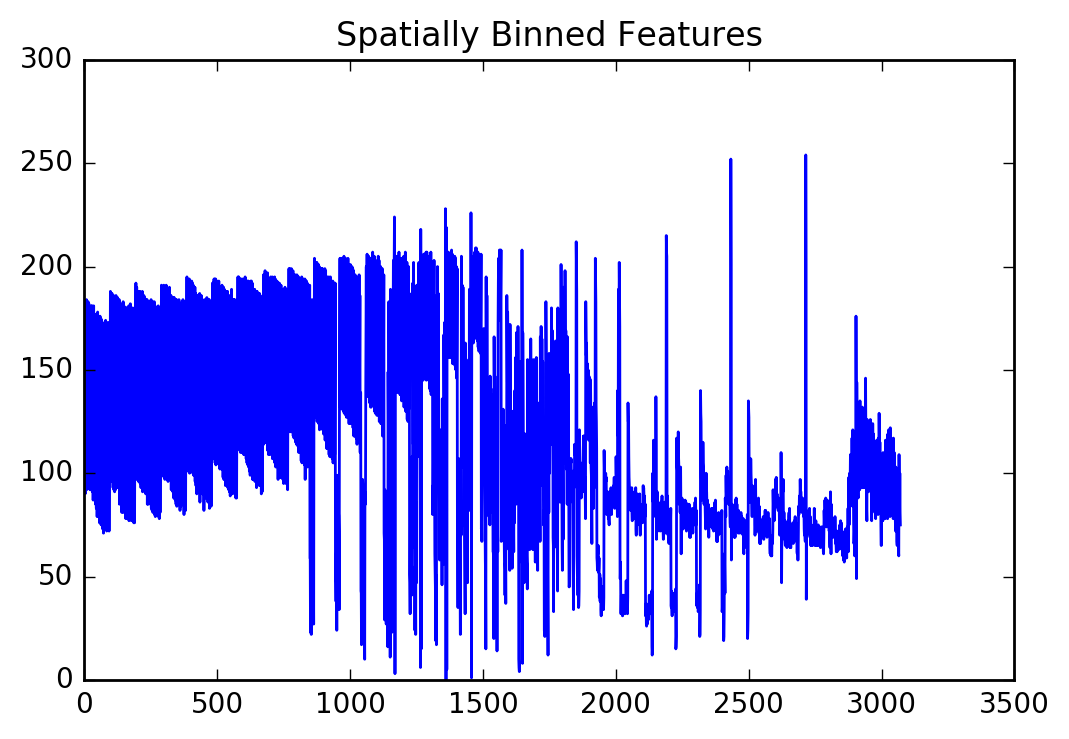

In [13]:
# img must be in RGB format
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        method = 'COLOR_RGB2' + color_space
        color_conversion = getattr(cv2,method)
        img_cvt = cv2.cvtColor(img, color_conversion)
    else:
        img_cvt = img
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img_cvt, size).ravel()
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(test_imgs[1], color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [16]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation



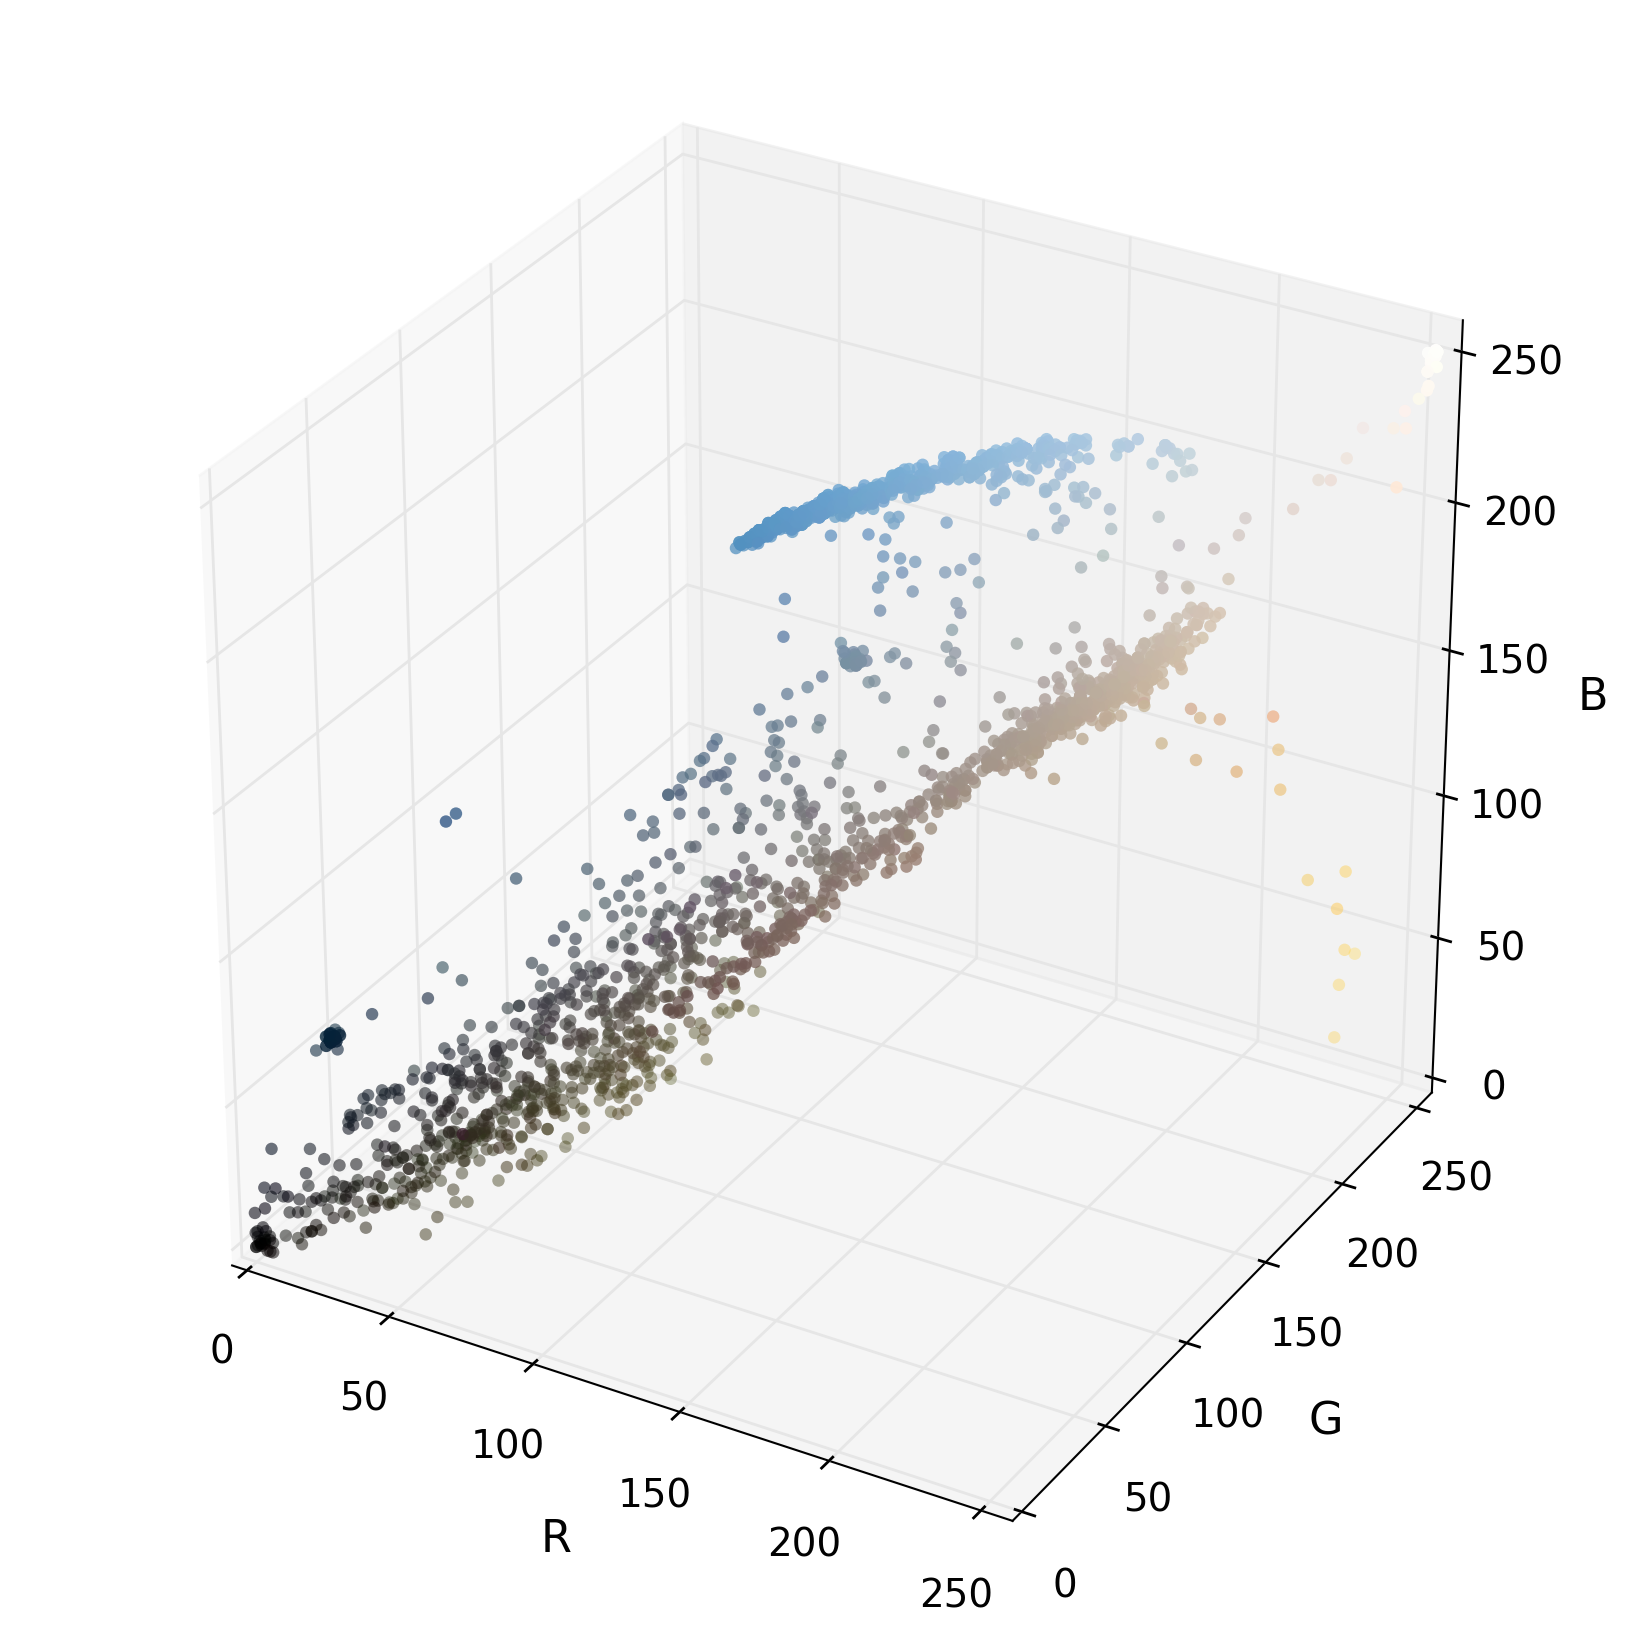

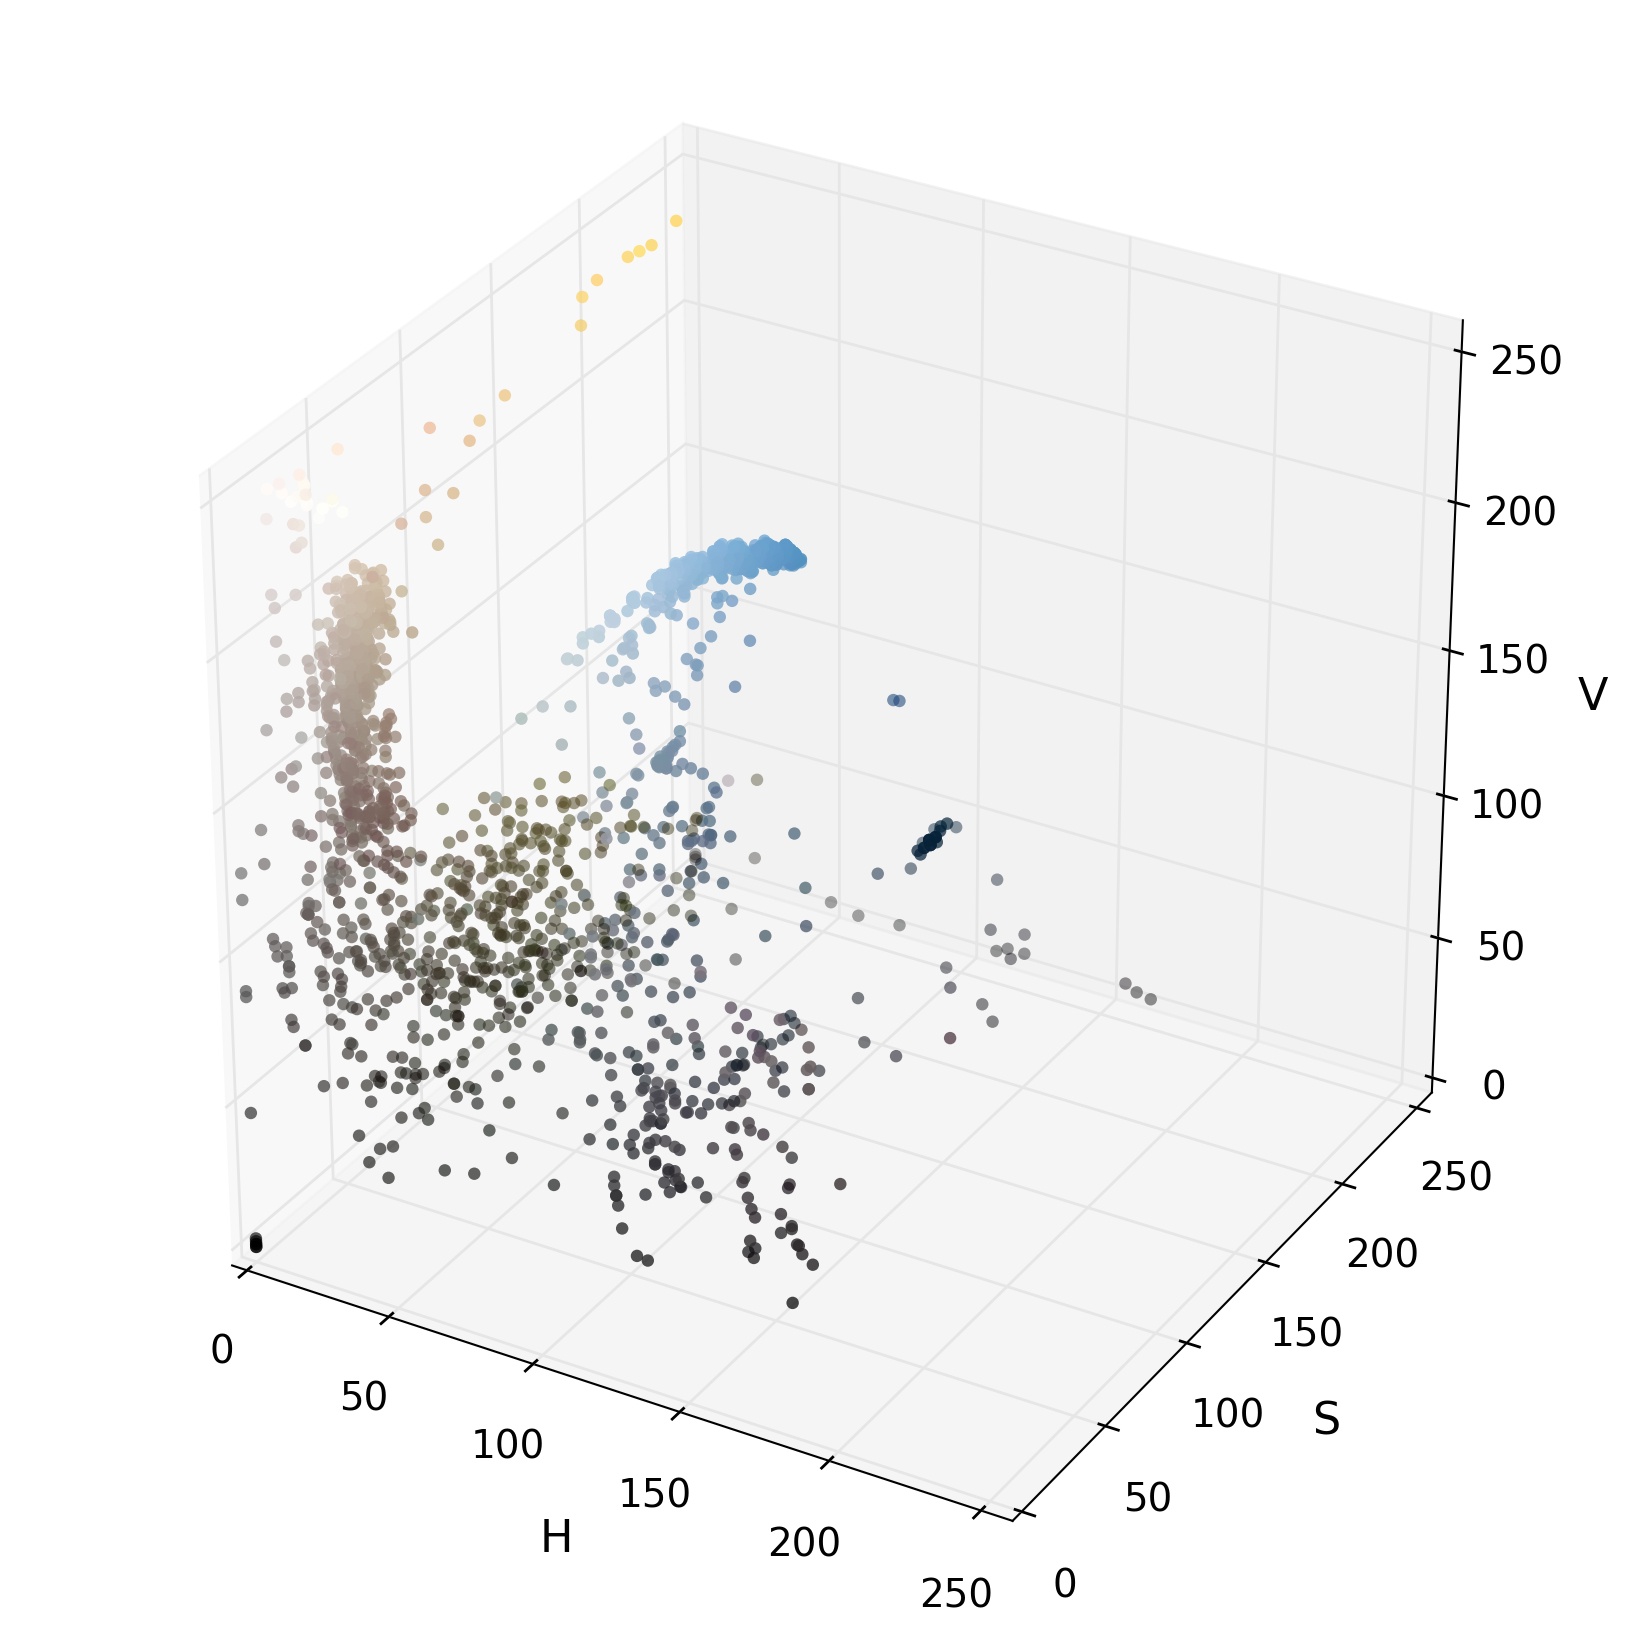

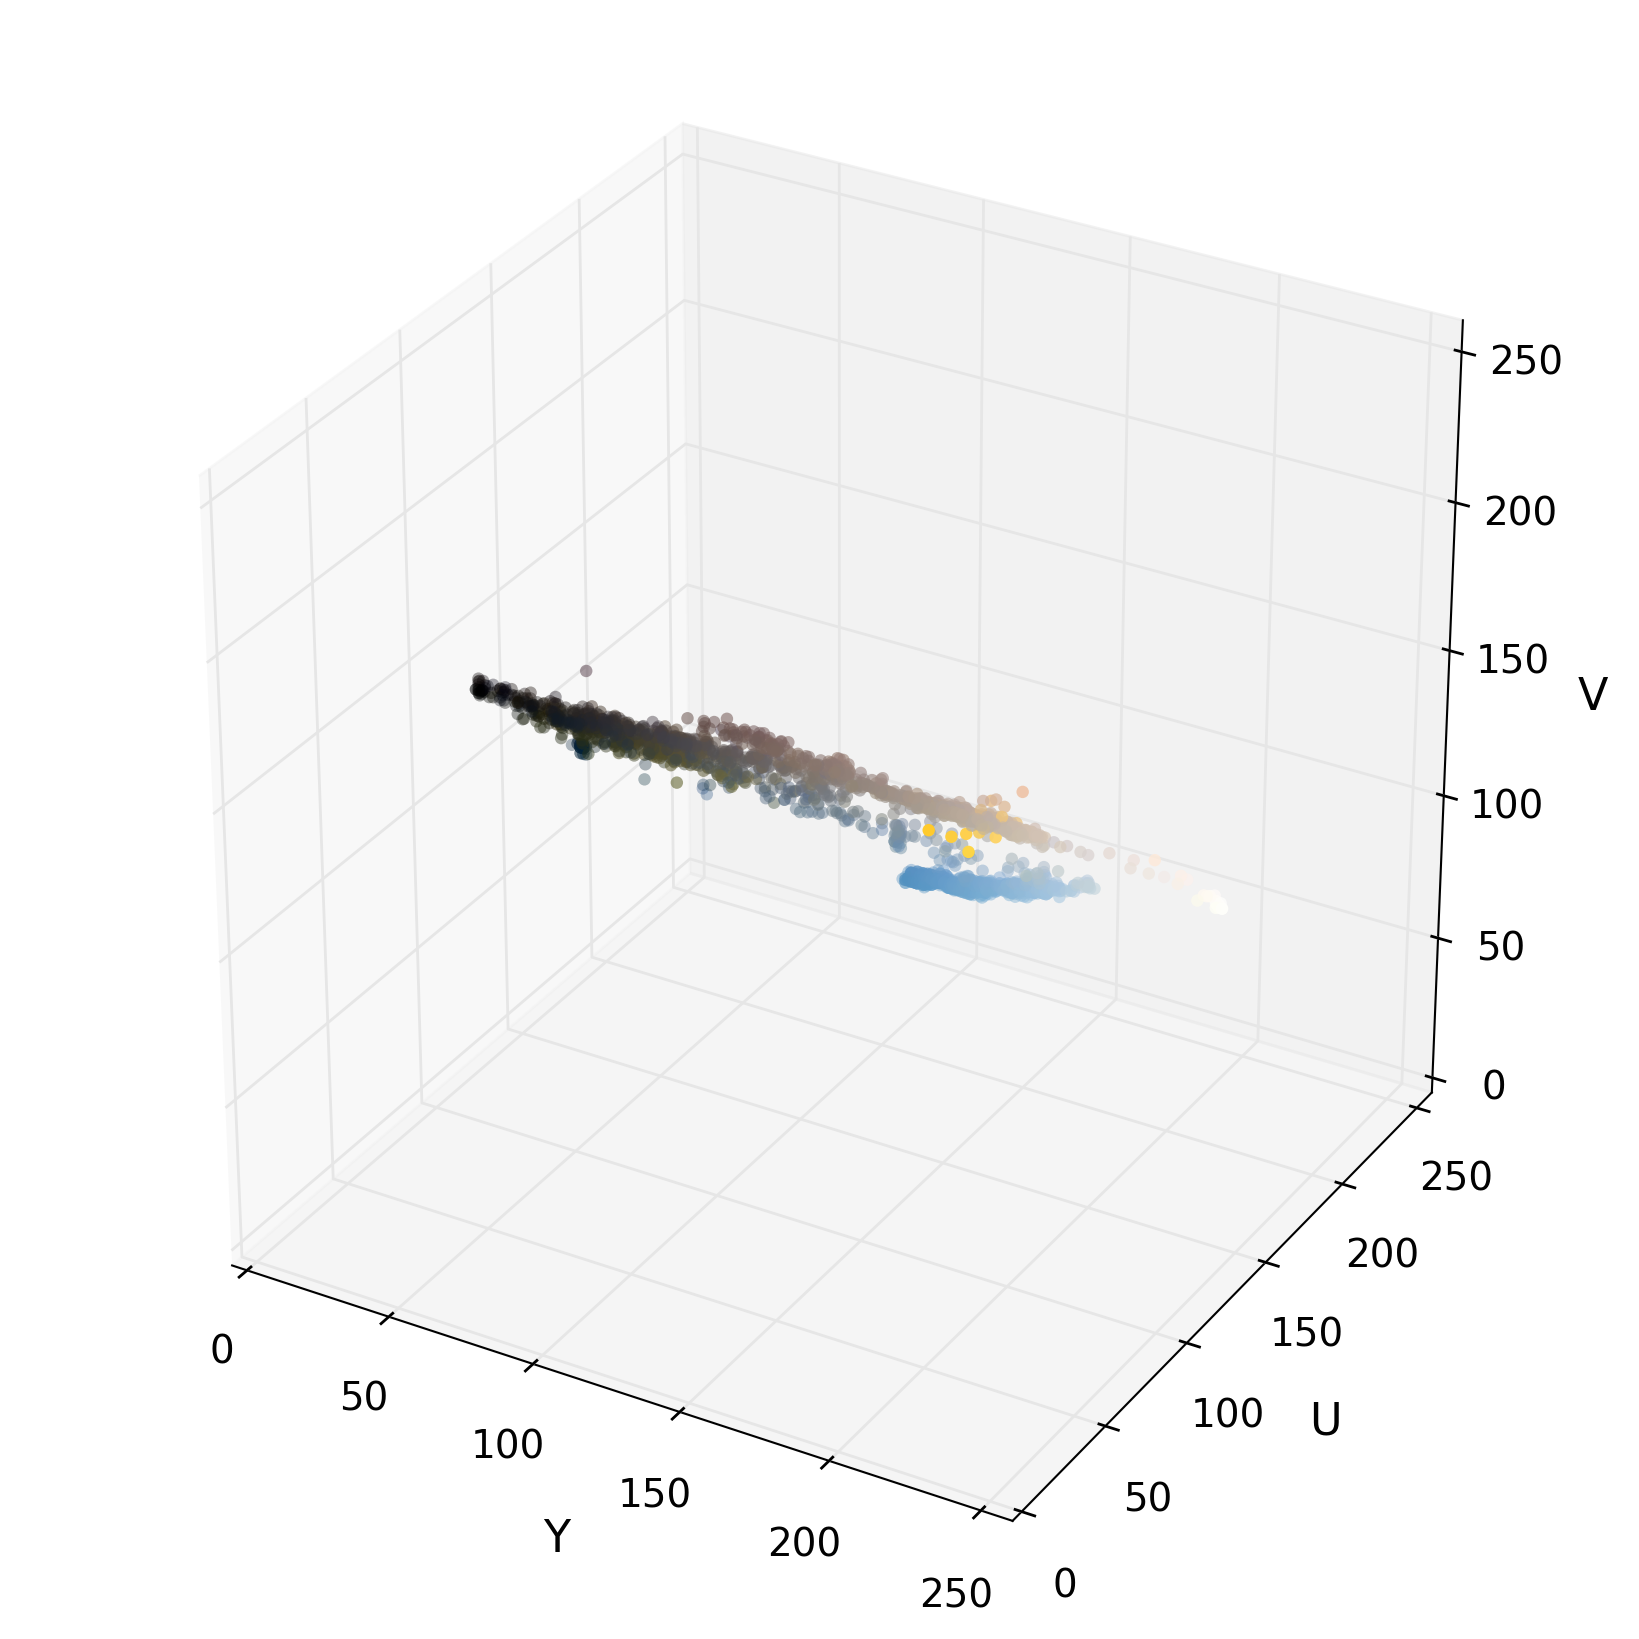

In [17]:
# Read a color image
img = test_imgs[0]

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = img_small # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_RGB2YUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plt.figure()
plot3d(img_small_RGB, img_small_rgb)
plt.show()
plt.figure()
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()
plt.figure()
plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
plt.show()

### HOG features

In [14]:
def get_hog_features(img, orient, pix_per_cell=(8,8), cell_per_block=(2,2), vis=False, feature_vec=True):
    hogdata = hog(img, orientations=orient, pixels_per_cell=pix_per_cell,
                    cells_per_block=cell_per_block, visualise=vis, feature_vector = feature_vec)
    if vis == True:       
        return hogdata[0], hogdata[1] #features, hogimage
    else:              
        return hogdata


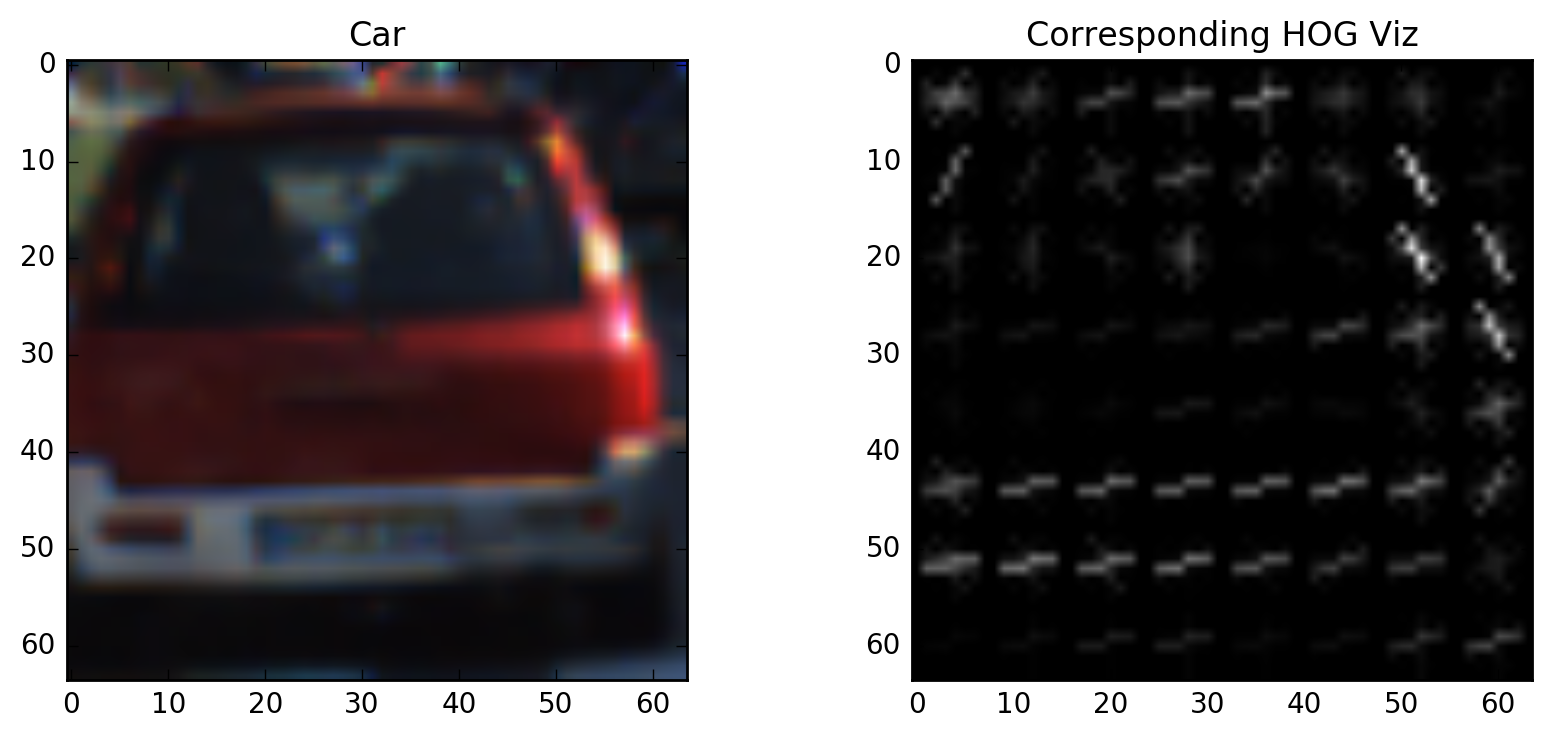

In [14]:
# test on random image
image = cv2.imread(cars[np.random.randint(0, len(cars))])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# HOG params
orient = 9
pix_per_cell = (8, 8)
cell_per_block = (2,2)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Car')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Corresponding HOG Viz')

---

### Classifying with color

In [15]:
#color histogram features  computation
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features.astype(np.float64)

# img must be in RGB format
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        method = 'COLOR_RGB2' + color_space
        color_conversion = getattr(cv2,method)
        img_cvt = cv2.cvtColor(img, color_conversion)
    else:
        img_cvt = img
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img_cvt, size).ravel()
    # Return the feature vector
    return features.astype(np.float64)

def extract_color_features(imgs_list, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for filepath in imgs_list:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
             
        # spatial color features
        spatial_features = bin_spatial(image, color_space=cspace, size=spatial_size)
        # color histogram features
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        # Join the 2 vfeature vectors together
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return np.array(features,dtype=np.float64)

In [73]:
extract_color_features(cars)

array([ 61,  46,  41, ..., 110,  78,  57], dtype=uint8)

In [16]:

def color_extract_test(spatial, histbin):
    cars_features = extract_color_features(cars, cspace='HSV', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    notcars_features = extract_color_features(notcars, cspace='HSV', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    X = np.vstack((cars_features, notcars_features))
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)
    y = np.hstack((np.ones(len(cars_features)), 
                  np.zeros(len(notcars_features))))

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=151)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    print('no. of training data samples: ',X_train.shape[0])
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc
# Check the prediction time for a single sample


In [17]:
spatial = 32
histbin = 64
svc_1=color_extract_test(spatial, histbin)

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 3264
no. of training data samples:  14208
23.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9521


In [88]:
spatial = 32
histbin = 128
svc_1=color_extract_test(spatial, histbin)

Using spatial binning of: 32 and 128 histogram bins
Feature vector length: 3456
no. of training data samples:  14208
15.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9561


In [89]:
spatial = 64
histbin = 128
svc_1=color_extract_test(spatial, histbin)

Using spatial binning of: 64 and 128 histogram bins
Feature vector length: 12672
no. of training data samples:  14208
78.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9476


In [84]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=151)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
print('no. of training data samples: ',X_train.shape[0])
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 3264
no. of training data samples:  14208
14.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9527


In [90]:
spatial = 16
histbin = 128
svc_1=color_extract_test(spatial, histbin)

Using spatial binning of: 16 and 128 histogram bins
Feature vector length: 1152
no. of training data samples:  14208
4.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9575


it seems like a value of histbin around 128 and spatial around 32 gives the best accuracy, although the test accurcay of various values didn't actually change a lot-- color features with HSV already gives a pretty decent result

---

### HOG classifier

In [20]:
def get_hog_features(img, orient, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    hogdata = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block,cell_per_block), visualise=vis, feature_vector = feature_vec)
    if vis == True:       
        return hogdata[0], hogdata[1] #features, hogimage
    else:              
        return hogdata

def extract_hog_features(imgs_list, color_space='HSV', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    # Iterate through the list of images
    for filepath in imgs_list:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            method = 'COLOR_RGB2' + color_space
            color_conversion = getattr(cv2, method)
            feature_image = cv2.cvtColor(image, color_conversion)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
#             print('hre')
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [34]:
def hog_extract_test(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    cars_features = extract_hog_features(cars[:500], color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    notcars_features = extract_hog_features(notcars[:500], color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    X = np.vstack((cars_features, notcars_features))
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)
    y = np.hstack((np.ones(len(cars_features)), 
                  np.zeros(len(notcars_features))))

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=151)

    print('Using orient:',orient, 'colorspace: ', colorspace,
        'pix_per_cell: ', pix_per_cell,'cell_per_block: ', cell_per_block, 'hog: ', hog_channel)
    print('Feature vector length:', len(X_train[0]))
    print('no. of training data samples: ',X_train.shape[0])
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc

In [13]:
colorspace = 'HSV' # Can be any valid colorspace in cv2
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
svc = hog_extract_test(colorspace, orient, pix_per_cell, cell_per_block, hog_channel)

Using orient: 9 pix_per_cell:  (8, 8) cell_per_block:  (2, 2) hog:  0
Feature vector length: 1764
no. of training data samples:  800
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.955


In [14]:
colorspace = 'HSV' # Can be any valid colorspace in cv2
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 1
svc = hog_extract_test(colorspace, orient, pix_per_cell, cell_per_block, hog_channel)

Using orient: 9 pix_per_cell:  (8, 8) cell_per_block:  (2, 2) hog:  1
Feature vector length: 1764
no. of training data samples:  800
0.1 Seconds to train SVC...
Test Accuracy of SVC =  0.94


In [15]:
colorspace = 'HSV' # Can be any valid colorspace in cv2
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = 0
svc = hog_extract_test(colorspace, orient, pix_per_cell, cell_per_block, hog_channel)

Using orient: 9 pix_per_cell:  (4, 4) cell_per_block:  (2, 2) hog:  0
Feature vector length: 8100
no. of training data samples:  800
0.25 Seconds to train SVC...
Test Accuracy of SVC =  0.97


In [22]:
colorspace = 'RGB' # Can be any valid colorspace in cv2
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = 'ALL'
svc = hog_extract_test(colorspace, orient, pix_per_cell, cell_per_block, hog_channel)

Using orient: 9 pix_per_cell:  (4, 4) cell_per_block:  (2, 2) hog:  ALL
Feature vector length: 24300
no. of training data samples:  800
0.74 Seconds to train SVC...
Test Accuracy of SVC =  0.995


In [29]:
hog_training_params= {'colorspaces': ['RGB', 'HSV', 'YUV'], 
         'orient': [8, 12, 16], 'pix_per_cell': [2,4,8], 
         'cell_per_block':[2,4], 'hog_channel': [0,1,2,'ALL']}


In [35]:
total = len(hog_training_params['colorspaces'] * len(hog_training_params['orient'])*
           len(hog_training_params['pix_per_cell']) * len(hog_training_params['cell_per_block']) * len(hog_training_params['hog_channel']))
i = 0
for cspace in hog_training_params['colorspaces']:
    for orient in hog_training_params['orient']:
        for pix in hog_training_params['pix_per_cell']:
            for cell in hog_training_params['cell_per_block']:
                for chan in hog_training_params['hog_channel']:
                    hog_extract_test(cspace, orient, pix, cell, chan)
                    i = i+1
                    print('done ', str(i))

Using orient: 8 colorspace:  RGB pix_per_cell:  2 cell_per_block:  2 hog:  0
Feature vector length: 30752
no. of training data samples:  800
0.95 Seconds to train SVC...
Test Accuracy of SVC =  0.99
done  1
Using orient: 8 colorspace:  RGB pix_per_cell:  2 cell_per_block:  2 hog:  1
Feature vector length: 30752
no. of training data samples:  800
0.97 Seconds to train SVC...
Test Accuracy of SVC =  0.99
done  2
Using orient: 8 colorspace:  RGB pix_per_cell:  2 cell_per_block:  2 hog:  2
Feature vector length: 30752
no. of training data samples:  800
0.91 Seconds to train SVC...
Test Accuracy of SVC =  0.995
done  3
Using orient: 8 colorspace:  RGB pix_per_cell:  2 cell_per_block:  2 hog:  ALL
Feature vector length: 92256
no. of training data samples:  800
2.79 Seconds to train SVC...
Test Accuracy of SVC =  0.99
done  4
Using orient: 8 colorspace:  RGB pix_per_cell:  2 cell_per_block:  4 hog:  0
Feature vector length: 107648
no. of training data samples:  800
4.88 Seconds to train SVC..

3.01 Seconds to train SVC...
Test Accuracy of SVC =  0.995
done  40
Using orient: 12 colorspace:  RGB pix_per_cell:  8 cell_per_block:  2 hog:  0
Feature vector length: 2352
no. of training data samples:  800
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.995
done  41
Using orient: 12 colorspace:  RGB pix_per_cell:  8 cell_per_block:  2 hog:  1
Feature vector length: 2352
no. of training data samples:  800
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.995
done  42
Using orient: 12 colorspace:  RGB pix_per_cell:  8 cell_per_block:  2 hog:  2
Feature vector length: 2352
no. of training data samples:  800
0.05 Seconds to train SVC...
Test Accuracy of SVC =  0.995
done  43
Using orient: 12 colorspace:  RGB pix_per_cell:  8 cell_per_block:  2 hog:  ALL
Feature vector length: 7056
no. of training data samples:  800
0.18 Seconds to train SVC...
Test Accuracy of SVC =  0.995
done  44
Using orient: 12 colorspace:  RGB pix_per_cell:  8 cell_per_block:  4 hog:  0
Feature vector l

done  79
Using orient: 8 colorspace:  HSV pix_per_cell:  2 cell_per_block:  4 hog:  ALL
Feature vector length: 322944
no. of training data samples:  800
22.0 Seconds to train SVC...
Test Accuracy of SVC =  1.0
done  80
Using orient: 8 colorspace:  HSV pix_per_cell:  4 cell_per_block:  2 hog:  0
Feature vector length: 7200
no. of training data samples:  800
0.26 Seconds to train SVC...
Test Accuracy of SVC =  0.93
done  81
Using orient: 8 colorspace:  HSV pix_per_cell:  4 cell_per_block:  2 hog:  1
Feature vector length: 7200
no. of training data samples:  800
0.21 Seconds to train SVC...
Test Accuracy of SVC =  0.925
done  82
Using orient: 8 colorspace:  HSV pix_per_cell:  4 cell_per_block:  2 hog:  2
Feature vector length: 7200
no. of training data samples:  800
0.15 Seconds to train SVC...
Test Accuracy of SVC =  1.0
done  83
Using orient: 8 colorspace:  HSV pix_per_cell:  4 cell_per_block:  2 hog:  ALL
Feature vector length: 21600
no. of training data samples:  800
0.8 Seconds to tr

Using orient: 12 colorspace:  HSV pix_per_cell:  8 cell_per_block:  4 hog:  ALL
Feature vector length: 14400
no. of training data samples:  800
0.5 Seconds to train SVC...
Test Accuracy of SVC =  0.99
done  120
Using orient: 16 colorspace:  HSV pix_per_cell:  2 cell_per_block:  2 hog:  0
Feature vector length: 61504
no. of training data samples:  800
2.31 Seconds to train SVC...
Test Accuracy of SVC =  0.955
done  121
Using orient: 16 colorspace:  HSV pix_per_cell:  2 cell_per_block:  2 hog:  1
Feature vector length: 61504
no. of training data samples:  800
2.77 Seconds to train SVC...
Test Accuracy of SVC =  0.96
done  122
Using orient: 16 colorspace:  HSV pix_per_cell:  2 cell_per_block:  2 hog:  2
Feature vector length: 61504
no. of training data samples:  800
2.3 Seconds to train SVC...
Test Accuracy of SVC =  1.0
done  123


KeyboardInterrupt: 

In the above, I stopped testing various params since it seems like they all have pretty good accuracy-- with RGB being rather better than HSV, and a reasonable set of params with low training time seem to be 8 pix per cell, 2 cell per block and using all HOG channels

---

#### Combining HOG, color classifiers

In [28]:
spatial = 32
histbin = 128
hog_channel = 'ALL'
orient = 9
colorspace = 'RGB'
def extract_color_features(imgs_list, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for filepath in imgs_list:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
             
        # spatial color features
        spatial_features = bin_spatial(image, color_space=cspace, size=spatial_size)
        # color histogram features
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        # Join the 2 vfeature vectors together
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return np.array(features,dtype=np.float64)

cars_features_col = extract_color_features(cars[:500], cspace='HSV', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
notcars_features_col = extract_color_features(notcars[:500], cspace='HSV', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
     
cars_features_hog = extract_hog_features(cars[:500], 'HSV', orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcars_features = extract_hog_features(notcars[:500], 'HSV', orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)



In [23]:
def hog_extract_test(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    cars_features = extract_hog_features(cars[:500], colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    notcars_features = extract_hog_features(notcars[:500], colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    X = np.vstack((cars_features, notcars_features))
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)
    y = np.hstack((np.ones(len(cars_features)), 
                  np.zeros(len(notcars_features))))

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=151)

    print('Using orient:',orient, 'colorspace: ', colorspace,
        'pix_per_cell: ', pix_per_cell,'cell_per_block: ', cell_per_block, 'hog: ', hog_channel)
    print('Feature vector length:', len(X_train[0]))
    print('no. of training data samples: ',X_train.shape[0])
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc

X = np.vstack((cars_features, notcars_features))
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)
y = np.hstack((np.ones(len(cars_features)), 
              np.zeros(len(notcars_features))))

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=151)

### Object detection with sliding windows

In [2]:
def car_detection(input_img, ystart, ystop, scale, svc, 
              X_scaler, cspace, orient, pix_per_cell, cell_per_block, 
                  spatial_size, hist_bins):
    
    img = np.copy(input_img)
    img = img.astype(np.float32)/255
    
    search_region = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        method = 'COLOR_RGB2' + color_space
        color_conversion = getattr(cv2, method)
        feature_image = cv2.cvtColor(search_region, color_conversion)
    else: 
        feature_image = np.copy(search_region)
    
    if scale != 1:
        imshape = feature_image.shape
        feature_image = cv2.resize(feature_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # the 3 color channels
    ch1 = feature_image[:,:,0]
    ch2 = feature_image[:,:,1]
    ch3 = feature_image[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(feature_image[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
spatial = 32
histbin = 128
pix_per_cell = 8 
cell_per_block = 2 
out_img = car_detection(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


NameError: name 'img' is not defined

In [3]:
color_hist

NameError: name 'color_hist' is not defined